In [ ]:
import os
from pathlib import Path

# Root folder where your dataset lives
root_dir = Path("/content/drive/MyDrive/archive (1)/sub-hc1/ses-hc/eeg")

# Grab all BDF, TSV, and JSON files from any depth
bdf_files = list(root_dir.rglob("*.bdf"))
tsv_files = list(root_dir.rglob("*.tsv"))
json_files = list(root_dir.rglob("*.json"))

print(f"Found {len(bdf_files)} BDF files")
print(f"Found {len(tsv_files)} TSV files")
print(f"Found {len(json_files)} JSON files")


Found 0 BDF files
Found 0 TSV files
Found 0 JSON files


In [ ]:
!pip install mne
import mne
re = mne.io.read_raw_bdf('/content/drive/MyDrive/parkinson/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf', preload=True)
print(re.info)

Extracting EDF parameters from /content/drive/MyDrive/parkinson/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2011-01-19 11:22:56 UTC
 nchan: 41
 projs: []
 sfreq: 512.0 Hz
 subject_info: <subject_info | his_id: >
>


.bdf, .meg , .eeg brain signals extension

In [ ]:
!pip install mne
import mne

# Example: read first BDF
raw = mne.io.read_raw_bdf(bdf_files[0], preload=True)
print(raw.info)

# Apply bandpass filter (e.g., 0.5–40 Hz for PD EEG)
raw.filter(0.5, 40)

# Plot 10 seconds to check quality
raw.plot(duration=10, n_channels=32)


IndexError: list index out of range

In [ ]:
import mne
import matplotlib.pyplot as plt


raw = mne.io.read_raw_bdf("/content/sub-hc1_ses-hc_task-rest_eeg.bdf", preload=True)
central_channels = ['C3', 'Cz', 'C4', 'CP1', 'CP2', 'FC1', 'FC2']
raw_picks = raw.pick_channels(central_channels)

# Plot the EEG signals for these channels
raw_picks.plot(n_channels=len(central_channels), duration=10, scalings='auto',
               title='Central EEG Channels (Motor Cortex - Parkinson Detection)',
               show=True, block=True)


In [ ]:
import mne
import os
import glob
import numpy as np

def load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0):
    """
    Load BDF EEG dataset with folder structure:
      sub-pdX/ses-on/eeg/*.bdf  -> PD ON
      sub-pdX/ses-off/eeg/*.bdf -> PD OFF
      sub-hcX/ses-hc/eeg/*.bdf  -> HC
    """
    X, y = [], []
    n_times = int(sfreq * epoch_len)

    # search recursively
    bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)
    print(f"Found {len(bdf_files)} BDF files under {base_path}")

    for f in bdf_files:
        f_low = f.lower()

        # infer label from session folder
        if "/ses-on/" in f_low:
            label = 1   # PD ON
        elif "/ses-off/" in f_low:
            label = 0   # PD OFF
        elif "/ses-hc/" in f_low:
            label = 2   # HC
        else:
            print(f"⚠️ Skipping (unknown label): {f}")
            continue

        try:
            raw = mne.io.read_raw_bdf(f, preload=True, verbose=False)
            raw.resample(sfreq)
            raw.pick_types(eeg=True)

            data = raw.get_data()  # (n_channels, n_times_total)
            n_channels, total_time = data.shape

            # segment into epochs
            step = n_times
            for start in range(0, total_time - n_times, step):
                segment = data[:, start:start+n_times]
                if segment.shape[1] == n_times:
                    X.append(segment)
                    y.append(label)

        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    if len(X) == 0:
        raise RuntimeError("No epochs extracted. Check paths and label rules.")

    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int")
    print("✅ Final dataset:", X.shape, y.shape)
    return X, y

# ---------------- Usage ----------------
path = "/content/drive/MyDrive/archive (1)"
X_data, y_data = load_bdf_dataset(path, sfreq=256, epoch_len=2.0)

# Save for later
np.save("X_epochs.npy", X_data)
np.save("y_labels.npy", y_data)


In [ ]:
from scipy.signal import welch

def extract_bandpower(data, sfreq, bands):
    features = []
    for epoch in data:
        ch_feats = []
        for ch in epoch:
            freqs, psd = welch(ch, sfreq, nperseg=sfreq*2)
            bp = [np.trapz(psd[(freqs>=low) & (freqs<high)], freqs[(freqs>=low) & (freqs<high)])
                  for low, high in bands]
            ch_feats.extend(bp)
        features.append(ch_feats)
    return np.array(features)

bands = [(0.5,4), (4,8), (8,13), (13,30), (30,40)]
X_feats = extract_bandpower(X, 256, bands)


In [ ]:
import numpy as np
from scipy.integrate import trapezoid
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Updated bandpower extraction to avoid DeprecationWarning
def extract_bandpower(data, sfreq, bands):
    features = []
    for epoch in data:
        ch_feats = []
        for ch in epoch:
            freqs, psd = welch(ch, sfreq, nperseg=sfreq*2)
            bp = [trapezoid(psd[(freqs >= low) & (freqs < high)],
                            freqs[(freqs >= low) & (freqs < high)])
                  for low, high in bands]
            ch_feats.extend(bp)
        features.append(ch_feats)
    return np.array(features)

# Frequency bands: delta, theta, alpha, beta, low-gamma
bands = [(0.5,4), (4,8), (8,13), (13,30), (30,40)]

# Extract features
X_feats = extract_bandpower(X, 256, bands)
print("Feature matrix shape:", X_feats.shape)  # Expect (n_epochs, channels*bands)
print("Labels shape:", y.shape)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_feats, y, test_size=0.2, random_state=42, stratify=y
)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.signal import welch
from scipy.integrate import trapezoid

# ---- user-config ----
SFREQ = 256
N_PLOT_CHANNELS = 8
RANDOM_SEED = 42
N_RANDOM_EPOCHS = 10
label_map = {0: "PD OFF", 1: "PD ON", 2: "HC"}
# ---------------------

# Try to use X and y from memory or load from disk
try:
    X_data = X
    y_data = y
    print("Using X and y from memory")
except NameError:
    if os.path.exists("X_epochs.npy") and os.path.exists("y_labels.npy"):
        X_data = np.load("X_epochs.npy", allow_pickle=True)
        y_data = np.load("y_labels.npy", allow_pickle=True)
        print(f"Loaded from .npy files: {X_data.shape}, {y_data.shape}")
    else:
        raise FileNotFoundError("No EEG data found.")

n_epochs, n_channels, n_times = X_data.shape
print(f"Dataset: {n_epochs} epochs, {n_channels} channels, {n_times} samples")

# Bandpower extraction
bands = [(0.5,4), (4,8), (8,13), (13,30), (30,40)]
def extract_bandpower(data, sfreq, bands):
    feats = []
    for ep in data:
        ch_feats = []
        for ch in ep:
            freqs, psd = welch(ch, sfreq, nperseg=sfreq*2)
            bp = [trapezoid(psd[(freqs>=low)&(freqs<high)],
                            freqs[(freqs>=low)&(freqs<high)]) for low, high in bands]
            ch_feats.extend(bp)
        feats.append(ch_feats)
    return np.array(feats)

# Train model if not already loaded
try:
    clf
    model = clf
    print("Using existing trained model.")
except NameError:
    print("Training quick RandomForest for demo...")
    X_feats_all = extract_bandpower(X_data, SFREQ, bands)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_feats_all, y_data, test_size=0.2, random_state=RANDOM_SEED, stratify=y_data
    )
    model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
    model.fit(X_tr, y_tr)
    print("Model trained.")

# Function to get bandpower features for a single epoch
def epoch_bandpower_single(epoch, sfreq, bands):
    ch_feats = []
    for ch in epoch:
        freqs, psd = welch(ch, sfreq, nperseg=sfreq*2)
        bp = [trapezoid(psd[(freqs>=low)&(freqs<high)],
                        freqs[(freqs>=low)&(freqs<high)]) for low, high in bands]
        ch_feats.extend(bp)
    return np.array(ch_feats).reshape(1, -1)

# Randomly pick N_RANDOM_EPOCHS and plot
random.seed(RANDOM_SEED)
indices = random.sample(range(n_epochs), N_RANDOM_EPOCHS)

for idx in indices:
    epoch = X_data[idx]
    true_label = int(y_data[idx])
    pred_feat = epoch_bandpower_single(epoch, SFREQ, bands)
    pred_label = int(model.predict(pred_feat)[0])

    # Time axis
    times = np.arange(n_times) / SFREQ
    ch_idx = list(range(min(N_PLOT_CHANNELS, n_channels)))

    # Plot
    plt.figure(figsize=(14, 6))
    offset = 0.0
    spacing = 1.5 * np.std(epoch)
    for i, ch in enumerate(ch_idx):
        trace = epoch[ch]
        plt.plot(times, trace + offset, label=f"Ch {ch}")
        plt.text(times[-1] + 0.02 * times[-1], offset, f"Ch{ch}", va='center')
        offset += spacing

    plt.xlabel("Time (s)")
    plt.yticks([])
    plt.title(f"Epoch {idx} — True: {label_map.get(true_label, true_label)} | "
              f"Predicted: {label_map.get(pred_label, pred_label)}")
    plt.tight_layout()
    plt.show()

    print(f"Epoch {idx}: True = {label_map.get(true_label, true_label)}, "
          f"Predicted = {label_map.get(pred_label, pred_label)}")


In [ ]:
# ---------- DenseNet EEG Pipeline ----------
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# ---------------- USER CONFIG ----------------
SFREQ = 256
RANDOM_SEED = 42
N_RANDOM_EPOCHS = 5
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 6
MODEL_SAVE = "densenet_eeg_best.h5"
label_map = {0: "PD OFF", 1: "PD ON", 2: "HC"}  # adjust as needed
# ---------------------------------------------

# Load data if not in memory
try:
    X_data, y_data
    print("Using X_data and y_data from memory.")
except NameError:
    if os.path.exists("X_epochs.npy") and os.path.exists("y_labels.npy"):
        X_data = np.load("X_epochs.npy", allow_pickle=True)
        y_data = np.load("y_labels.npy", allow_pickle=True)
        print("Loaded X_epochs.npy and y_labels.npy")
    else:
        raise FileNotFoundError("X_data/y_data not present and .npy files not found.")

# Basic info
n_epochs, n_channels, n_times = X_data.shape
n_classes = len(np.unique(y_data))
print(f"Data shape: {X_data.shape}, classes: {n_classes}")

# Reshape to (samples, chans, times, 1)
X = X_data.astype("float32").reshape((n_epochs, n_channels, n_times, 1))
y = y_data.astype(int)

# Normalize (z-score per epoch)
X = (X - X.mean(axis=2, keepdims=True)) / (X.std(axis=2, keepdims=True) + 1e-10)

# One-hot encode labels
lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)
if y_onehot.shape[1] == 1:  # binary → two-column
    y_onehot = np.hstack([1 - y_onehot, y_onehot])
print("One-hot shape:", y_onehot.shape)

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_onehot, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=RANDOM_SEED,
    stratify=np.argmax(y_temp, axis=1)
)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---------- DenseNet-like EEG model ----------
def DenseNetEEG(nb_classes, Chans, Samples, growth_rate=12, num_blocks=3, dropoutRate=0.5):
    """
    Compact DenseNet for EEG classification
    """
    input1 = layers.Input(shape=(Chans, Samples, 1))

    # Initial conv
    x = layers.Conv2D(16, (3,3), padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(1e-4))(input1)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Dense blocks
    for b in range(num_blocks):
        y = layers.BatchNormalization()(x)
        y = layers.Activation("relu")(y)
        y = layers.Conv2D(4*growth_rate, (1,1), padding="same", use_bias=False)(y)

        y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)
        y = layers.Conv2D(growth_rate, (3,3), padding="same", use_bias=False)(y)
        if dropoutRate:
            y = layers.Dropout(dropoutRate)(y)

        x = layers.Concatenate()([x, y])

        if b != num_blocks - 1:
            x = layers.BatchNormalization()(x)
            x = layers.Conv2D(x.shape[-1]//2, (1,1), padding="same", use_bias=False)(x)
            x = layers.AveragePooling2D((2,2))(x)

    # Classifier
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(nb_classes, activation="softmax")(x)

    model = models.Model(inputs=input1, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build model
model = DenseNetEEG(n_classes, n_channels, n_times)
model.summary()

# Callbacks
es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
mc = callbacks.ModelCheckpoint(MODEL_SAVE, monitor="val_loss", save_best_only=True)
rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[es, mc, rlrop],
    verbose=2
)

# Save final model
model.save("densenet_eeg_final.h5")

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.show()

# ---------- Evaluate on test set ----------
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=[label_map.get(i,str(i)) for i in range(n_classes)]))
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))

# ---------- Plot random epochs ----------
def epoch_to_model_input(epoch_array):
    arr = epoch_array.reshape(1, n_channels, n_times, 1).astype("float32")
    arr = (arr - arr.mean(axis=2, keepdims=True)) / (arr.std(axis=2, keepdims=True) + 1e-10)
    return arr

random.seed(RANDOM_SEED)
indices = random.sample(range(n_epochs), N_RANDOM_EPOCHS)
for idx in indices:
    epoch = X_data[idx]
    model_in = epoch_to_model_input(epoch)
    p = model.predict(model_in)
    pred_label = int(np.argmax(p, axis=1)[0])
    true_label = int(y_data[idx])

    times = np.arange(n_times) / SFREQ
    plt.figure(figsize=(12,4))
    offset = 0.0
    spacing = 1.5 * np.std(epoch)
    for i,ch in enumerate(range(min(8, n_channels))):
        plt.plot(times, epoch[ch] + offset)
        plt.text(times[-1] + 0.02*times[-1], offset, f"Ch{ch}", va="center")
        offset += spacing
    plt.title(f"Epoch {idx} — True: {label_map.get(true_label,true_label)} | Pred: {label_map.get(pred_label,pred_label)}")
    plt.xlabel("Time (s)")
    plt.yticks([])
    plt.tight_layout()
    plt.show()
    print(f"Epoch {idx}: True={label_map.get(true_label,true_label)}, Pred={label_map.get(pred_label,pred_label)}")


In [ ]:
import mne
import os
import glob
import numpy as np

def load_bdf_dataset(base_path, label_map, sfreq=256, epoch_len=2.0):
    """
    Recursively load BDF files and preprocess into epochs.
    Assumes subfolders/filenames contain 'hc', 'pdon', 'pdoff'.
    """
    X, y = [], []
    n_times = int(sfreq * epoch_len)

    # search all .bdf files recursively
    bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)
    bdf_files += glob.glob(os.path.join(base_path, "**", "*.BDF"), recursive=True)

    print(f"Found {len(bdf_files)} BDF files in {base_path}")

    for f in bdf_files:
        label = None
        fname = f.lower()
        if "hc" in fname:
            label = 2  # HC
        elif "pdon" in fname or "pd_on" in fname:
            label = 1  # PD ON
        elif "pdoff" in fname or "pd_off" in fname:
            label = 0  # PD OFF

        if label is None:
            print(f"⚠️ Skipping {f} (label not recognized)")
            continue

        try:
            raw = mne.io.read_raw_bdf(f, preload=True, verbose=False)
            raw.resample(sfreq)
            raw.pick_types(eeg=True)

            data = raw.get_data()
            n_channels, total_time = data.shape
            step = n_times
            for start in range(0, total_time - n_times, step):
                segment = data[:, start:start+n_times]
                if segment.shape[1] == n_times:
                    X.append(segment)
                    y.append(label)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="int")
    print("Final dataset:", X.shape, y.shape)
    return X, y

# ---------------- Usage ----------------
path = '/content/drive/MyDrive/archive (1)'
X_data, y_data = load_bdf_dataset(path, label_map, sfreq=SFREQ, epoch_len=2.0)

# Save for reuse
np.save("X_epochs.npy", X_data)
np.save("y_labels.npy", y_data)


In [ ]:
# ---------- ResNet EEG Pipeline ----------
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# ---------------- USER CONFIG ----------------
SFREQ = 256
RANDOM_SEED = 42
N_RANDOM_EPOCHS = 5
BATCH_SIZE = 32
EPOCHS = 20
PATIENCE = 6
MODEL_SAVE = "resnet30_eeg_best.h5"
label_map = {0: "PD OFF", 1: "PD ON", 2: "HC"}  # adjust as needed
# ---------------------------------------------

# Load data if not in memory
try:
    X_data, y_data
    print("Using X_data and y_data from memory.")
except NameError:
    if os.path.exists("X_epochs.npy") and os.path.exists("y_labels.npy"):
        X_data = np.load("X_epochs.npy", allow_pickle=True)
        y_data = np.load("y_labels.npy", allow_pickle=True)
        print("Loaded X_epochs.npy and y_labels.npy")
    else:
        raise FileNotFoundError("X_data/y_data not present and .npy files not found.")

# Basic info
n_epochs, n_channels, n_times = X_data.shape
n_classes = len(np.unique(y_data))
print(f"Data shape: {X_data.shape}, classes: {n_classes}")

# Reshape to (samples, chans, times, 1)
X = X_data.astype("float32").reshape((n_epochs, n_channels, n_times, 1))
y = y_data.astype(int)

# Normalize (z-score per epoch)
X = (X - X.mean(axis=2, keepdims=True)) / (X.std(axis=2, keepdims=True) + 1e-10)

# One-hot encode labels
lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)
if y_onehot.shape[1] == 1:  # binary → two-column
    y_onehot = np.hstack([1 - y_onehot, y_onehot])
print("One-hot shape:", y_onehot.shape)

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_onehot, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=RANDOM_SEED,
    stratify=np.argmax(y_temp, axis=1)
)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---------- ResNet-30 EEG model ----------
def residual_block(x, filters, stride=1):
    shortcut = x

    # First conv
    y = layers.Conv2D(filters, (3,3), strides=stride, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4), use_bias=False)(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)

    # Second conv
    y = layers.Conv2D(filters, (3,3), padding="same",
                      kernel_regularizer=regularizers.l2(1e-4), use_bias=False)(y)
    y = layers.BatchNormalization()(y)

    # Match dimensions if needed
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, (1,1), strides=stride, padding="same",
                                 use_bias=False, kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    out = layers.Add()([shortcut, y])
    out = layers.Activation("relu")(out)
    return out

def ResNet30EEG(nb_classes, Chans, Samples):
    """
    ResNet-30 style compact model for EEG classification
    """
    input1 = layers.Input(shape=(Chans, Samples, 1))

    # Initial conv
    x = layers.Conv2D(32, (3,3), strides=1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(1e-4))(input1)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Residual blocks (approx. 30 layers: conv+BN+ReLU counted)
    filters = [32, 64, 128, 256]
    strides = [1, 2, 2, 2]
    for f, s in zip(filters, strides):
        x = residual_block(x, f, stride=s)
        x = residual_block(x, f, stride=1)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(nb_classes, activation="softmax")(x)

    model = models.Model(inputs=input1, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Build model
model = ResNet30EEG(n_classes, n_channels, n_times)
model.summary()

# Callbacks
es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
mc = callbacks.ModelCheckpoint(MODEL_SAVE, monitor="val_loss", save_best_only=True)
rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[es, mc, rlrop],
    verbose=2
)

# Save final model
model.save("resnet30_eeg_final.h5")

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy")
plt.show()

# ---------- Evaluate on test set ----------
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=[label_map.get(i,str(i)) for i in range(n_classes)]))
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))

# ---------- Plot random epochs ----------
def epoch_to_model_input(epoch_array):
    arr = epoch_array.reshape(1, n_channels, n_times, 1).astype("float32")
    arr = (arr - arr.mean(axis=2, keepdims=True)) / (arr.std(axis=2, keepdims=True) + 1e-10)
    return arr

random.seed(RANDOM_SEED)
indices = random.sample(range(n_epochs), N_RANDOM_EPOCHS)
for idx in indices:
    epoch = X_data[idx]
    model_in = epoch_to_model_input(epoch)
    p = model.predict(model_in)
    pred_label = int(np.argmax(p, axis=1)[0])
    true_label = int(y_data[idx])

    times = np.arange(n_times) / SFREQ
    plt.figure(figsize=(12,4))
    offset = 0.0
    spacing = 1.5 * np.std(epoch)
    for i,ch in enumerate(range(min(8, n_channels))):
        plt.plot(times, epoch[ch] + offset)
        plt.text(times[-1] + 0.02*times[-1], offset, f"Ch{ch}", va="center")
        offset += spacing
    plt.title(f"Epoch {idx} — True: {label_map.get(true_label,true_label)} | Pred: {label_map.get(pred_label,pred_label)}")
    plt.xlabel("Time (s)")
    plt.yticks([])
    plt.tight_layout()
    plt.show()
    print(f"Epoch {idx}: True={label_map.get(true_label,true_label)}, Pred={label_map.get(pred_label,pred_label)}")


In [ ]:
!pip install mne
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:

!pip install mne
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import swin_t

from scipy.signal import stft

# -------------------------
# 1) Preprocess EEG
# -------------------------
def preprocess_eeg(file_path, duration=5.0, resample_rate=256):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        try:
            raw.set_montage("standard_1020")
        except:
            pass
        raw.filter(1., 40., fir_design='firwin')
        raw.notch_filter([50])
        raw.set_eeg_reference('average', projection=True)
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)
        X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        return X
    except:
        return None

# -------------------------
# 2) Convert EEG epoch -> Spectrogram image
# -------------------------
def epoch_to_spectrogram(epoch, n_fft=128):
    # epoch: (n_channels, n_times)
    imgs = []
    for ch in range(epoch.shape[0]):
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        img = np.abs(Zxx)
        imgs.append(img)
    img = np.stack(imgs[:3], axis=0)  # take first 3 channels for 3 RGB-like channels
    if img.shape[0] < 3:  # pad if <3 channels
        img = np.pad(img, ((0,3-img.shape[0]), (0,0),(0,0)), mode='constant')
    return img.astype(np.float32)

# -------------------------
# 3) Dataset
# -------------------------
class EEGDataset(Dataset):
    def __init__(self, eeg_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        for root, dirs, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None:
                        continue
                    # Label from filename
                    fname = f.lower()
                    if 'hc' in fname:
                        label = 0
                    elif 'pd-on' in fname:
                        label = 1
                    elif 'pd-off' in fname:
                        label = 2
                    else:
                        label = 1  # default to pd-on if unsure
                    # convert each epoch to spectrogram
                    for epoch in X:
                        img = epoch_to_spectrogram(epoch)
                        self.samples.append(img)
                        self.labels.append(label)
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(torch.tensor(img))
        return img, label

# -------------------------
# 4) Train/Validation split
# -------------------------
from sklearn.model_selection import train_test_split

# -------------------------
# 5) Training function
# -------------------------
def train_model(dataset, epochs=3, batch_size=8, lr=1e-4, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((224,224)),  # Swin Transformer expects 224x224
    ])
    # Split train/val
    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)

    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = swin_t(weights=None, num_classes=3).to(device)  # pretrained=None for Kaggle offline
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0,0,0
        for imgs, labels in loader_train:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
        train_loss = total_loss/total
        train_acc = correct/total

        # Validation
        model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()*imgs.size(0)
                _, preds = torch.max(outputs,1)
                correct += (preds==labels).sum().item()
                total += imgs.size(0)
        val_loss = total_loss/total
        val_acc = correct/total

        print(f"Epoch {epoch}/{epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_swin_model.pth")
    print("Best Validation Accuracy:", best_acc)

# -------------------------
# 6) Run
# -------------------------
if __name__ == "__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"
    dataset = EEGDataset(eeg_dir)
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_model(dataset, epochs=5, batch_size=4, device=device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 66.4 MB/s eta 0:00:00
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transiti

In [ ]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm  # Use timm to import DeiT
from scipy.signal import stft
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# -------------------------
# 1) Preprocess EEG
# -------------------------
def preprocess_eeg(file_path, duration=5.0, resample_rate=256):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        try:
            raw.set_montage("standard_1020")
        except:
            pass
        raw.filter(1., 40., fir_design='firwin')
        raw.notch_filter([50])
        raw.set_eeg_reference('average', projection=True)
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)
        X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        return X
    except:
        return None

# -------------------------
# 2) Convert EEG epoch -> Spectrogram image
# -------------------------
from torchvision.transforms import functional as F

def epoch_to_spectrogram(epoch, n_fft=128, resize_to=(224, 224)):
    imgs = []
    for ch in range(epoch.shape[0]):
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        img = np.abs(Zxx)
        imgs.append(img)
    img = np.stack(imgs[:3], axis=0)  # take first 3 channels for 3 RGB-like channels
    if img.shape[0] < 3:  # pad if <3 channels
        img = np.pad(img, ((0,3-img.shape[0]), (0,0),(0,0)), mode='constant')

    img = np.array(img, dtype=np.float32)
    # Resize to the target size (224x224)
    img = F.resize(torch.tensor(img), resize_to)
    return img

# -------------------------
# 3) Dataset
# -------------------------
class EEGDataset(Dataset):
    def __init__(self, eeg_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        for root, dirs, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None:
                        continue
                    # Label from filename
                    fname = f.lower()
                    if 'hc' in fname:
                        label = 0
                    elif 'pd-on' in fname:
                        label = 1
                    elif 'pd-off' in fname:
                        label = 2
                    else:
                        label = 1  # default to pd-on if unsure
                    # convert each epoch to spectrogram
                    for epoch in X:
                        img = epoch_to_spectrogram(epoch)
                        self.samples.append(img)
                        self.labels.append(label)
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(torch.tensor(img))
        return img, label

# -------------------------
# 4) Training function with Regularization & Scheduler
# -------------------------
def train_model(dataset, epochs=10, batch_size=8, lr=1e-4, device='cuda'):
    # Data Augmentation for Training
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),   # Added random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resizing & cropping
        transforms.ToTensor(),  # Convert to tensor
    ])

    # Transform for validation (no augmentation)
    transform_val = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])

    # Split train/val
    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)

    # Apply transformations
    train_set.transform = transform_train
    val_set.transform = transform_val

    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Initialize DeiT model using timm
    model = timm.create_model('deit_base_patch16_224', pretrained=False, num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in loader_train:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += imgs.size(0)

        val_loss = total_loss / total
        val_acc = correct / total

        print(f"Epoch {epoch}/{epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Save the model with the best validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_deit_model.pth")

    print("Best Validation Accuracy:", best_acc)

# -------------------------
# 5) Run
# -------------------------
if __name__ == "__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"
    dataset = EEGDataset(eeg_dir)
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_model(dataset, epochs=10, batch_size=8, device=device)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

convxnet


In [ ]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import convnext_base, vit_b_16, swin_t
from scipy.signal import stft
from sklearn.model_selection import train_test_split

# -------------------------
# 1) Preprocess EEG
# -------------------------
def preprocess_eeg(file_path, duration=5.0, resample_rate=256):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        try:
            raw.set_montage("standard_1020")
        except:
            pass
        raw.filter(1., 40., fir_design='firwin')
        raw.notch_filter([50])
        raw.set_eeg_reference('average', projection=True)
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)
        X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        return X
    except:
        return None

# -------------------------
# 2) Convert EEG epoch -> Spectrogram image
# -------------------------
def epoch_to_spectrogram(epoch, n_fft=128):
    imgs = []
    for ch in range(epoch.shape[0]):
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        img = np.abs(Zxx)
        imgs.append(img)
    img = np.stack(imgs[:3], axis=0)  # take first 3 channels for RGB-like channels
    if img.shape[0] < 3:
        img = np.pad(img, ((0,3-img.shape[0]), (0,0),(0,0)), mode='constant')
    return img.astype(np.float32)

# -------------------------
# 3) Dataset
# -------------------------
class EEGDataset(Dataset):
    def __init__(self, eeg_dir, transform=None):
        self.samples = []
        self.labels = []
        self.transform = transform
        for root, dirs, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None:
                        continue
                    # Label from filename
                    fname = f.lower()
                    if 'hc' in fname:
                        label = 0
                    elif 'pd-on' in fname:
                        label = 1
                    elif 'pd-off' in fname:
                        label = 2
                    else:
                        label = 1  # default to pd-on if unsure
                    for epoch in X:
                        img = epoch_to_spectrogram(epoch)
                        self.samples.append(img)
                        self.labels.append(label)
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(torch.tensor(img))
        return img, label

# -------------------------
# 4) Model selector
# -------------------------
def build_model(model_name='convnext', num_classes=3):
    if model_name == 'convnext':
        model = convnext_base(weights=None)
        in_features = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(in_features, num_classes)
    elif model_name == 'vit':
        model = vit_b_16(weights=None, num_classes=num_classes)
    elif model_name == 'swin':
        model = swin_t(weights=None, num_classes=num_classes)
    else:
        raise ValueError("Choose from 'convnext', 'vit', or 'swin'")
    return model

# -------------------------
# 5) Training function
# -------------------------
def train_model(dataset, model_name='convnext', epochs=3, batch_size=8, lr=1e-4, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((224,224)),  # All 3 models expect 224x224
    ])

    # Apply transform to dataset
    dataset.transform = transform

    # Train/val split
    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2,
                                          stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)
    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = build_model(model_name=model_name, num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(1, epochs+1):
        # Training
        model.train()
        total_loss, correct, total = 0,0,0
        for imgs, labels in loader_train:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
        train_loss = total_loss/total
        train_acc = correct/total

        # Validation
        model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()*imgs.size(0)
                _, preds = torch.max(outputs,1)
                correct += (preds==labels).sum().item()
                total += imgs.size(0)
        val_loss = total_loss/total
        val_acc = correct/total

        print(f"Epoch {epoch}/{epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{model_name}_model.pth")
    print("Best Validation Accuracy:", best_acc)

# -------------------------
# 6) Run
# -------------------------
if __name__ == "__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"
    dataset = EEGDataset(eeg_dir)
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Example usage:
    train_model(dataset, model_name='convnext', epochs=3, batch_size=4, device=device)
    train_model(dataset, model_name='vit', epochs=3, batch_size=4, device=device)
    #train_model(dataset, model_name='swin', epochs=3, batch_size=4, device=device)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

KeyboardInterrupt: 

In [ ]:
import os
import mne
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import convnext_tiny
from scipy.signal import stft
from sklearn.model_selection import train_test_split

# -------------------------
# 1) Fast EEG preprocessing
# -------------------------
def preprocess_eeg_fast(file_path, duration=5.0, resample_rate=128):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        try:
            raw.set_montage("standard_1020")
        except:
            pass
        raw.filter(1., 40., fir_design='firwin')
        raw.notch_filter([50])
        raw.set_eeg_reference('average', projection=True)
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)
        X = epochs.get_data()
        return X
    except:
        return None

# -------------------------
# 2) Epoch -> spectrogram
# -------------------------
def epoch_to_spectrogram_fast(epoch, n_fft=64):
    imgs = []
    for ch in range(min(3, epoch.shape[0])):
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        img = np.abs(Zxx)
        imgs.append(img)
    imgs = np.stack(imgs, axis=0)
    imgs_resized = np.zeros((3,128,128), dtype=np.float32)
    for i in range(3):
        imgs_resized[i] = np.array(transforms.Resize((128,128))(torch.tensor(imgs[i])[None,:,:]))[0]
    return imgs_resized

# -------------------------
# 3) Fast EEG dataset
# -------------------------
class EEGDatasetFast(Dataset):
    def __init__(self, eeg_dir, max_files=5):
        self.samples, self.labels = [], []
        count_files = 0
        for root, dirs, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg_fast(path)
                    if X is None or len(X)==0:
                        continue
                    fname = f.lower()
                    if 'hc' in fname: label=0
                    elif 'pd-on' in fname: label=1
                    elif 'pd-off' in fname: label=2
                    else: label=1
                    for epoch in X:
                        self.samples.append(epoch_to_spectrogram_fast(epoch))
                        self.labels.append(label)
                    count_files += 1
                    if count_files>=max_files:
                        break
            if count_files>=max_files:
                break
        if len(self.samples)==0:
            raise RuntimeError(f"No EEG data found in {eeg_dir}")
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx]), torch.tensor(self.labels[idx])

# -------------------------
# 4) Training
# -------------------------
def train_fast(dataset, model_name='convnext', epochs=3, batch_size=16, lr=1e-4, device='cuda'):
    train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)
    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # -------------------------
    # Model
    # -------------------------
    num_classes = 3
    if model_name=='convnext':
        model = convnext_tiny(weights=None)
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
    else:
        raise NotImplementedError("Only ConvNeXt implemented for speed")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Training loop
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0,0,0
        for imgs, labels in loader_train:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
        train_loss, train_acc = total_loss/total, correct/total

        # Validation
        model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()*imgs.size(0)
                _, preds = torch.max(outputs,1)
                correct += (preds==labels).sum().item()
                total += imgs.size(0)
        val_loss, val_acc = total_loss/total, correct/total
        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")
        if val_acc>best_acc:
            best_acc=val_acc
            torch.save(model.state_dict(),"best_convnext_fast.pth")
    print("Best Val Accuracy:", best_acc)

# -------------------------
# 5) Run
# -------------------------
if __name__=="__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"  # adjust path
    dataset = EEGDatasetFast(eeg_dir, max_files=5)
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_fast(dataset, model_name='convnext', epochs=3, batch_size=16, device=device)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, convnext_base
from scipy.signal import stft
import mne

# -------------------------
# 1) Preprocess EEG
# -------------------------
def preprocess_eeg(file_path, duration=5.0, resample_rate=256):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        raw.filter(1., 40., fir_design='firwin')
        raw.notch_filter([50])
        raw.set_eeg_reference('average', projection=True)
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True)
        X = epochs.get_data()  # (n_epochs, n_channels, n_times)
        return X
    except:
        return None

# -------------------------
# 2) Convert epoch -> spectrogram
# -------------------------
def epoch_to_spectrogram(epoch, n_fft=64):
    imgs = []
    for ch in range(epoch.shape[0]):
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        imgs.append(np.abs(Zxx))
    img = np.stack(imgs[:3], axis=0)  # first 3 channels as RGB
    if img.shape[0] < 3:
        img = np.pad(img, ((0,3-img.shape[0]),(0,0),(0,0)), mode='constant')
    return img.astype(np.float32)

# -------------------------
# 3) Dataset
# -------------------------
class EEGDatasetFast(Dataset):
    def __init__(self, eeg_dir, max_files=10, transform=None):
        self.samples, self.labels = [], []
        self.transform = transform
        files_count = 0
        for root, _, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None:
                        continue
                    # simple label from filename
                    fname = f.lower()
                    if 'hc' in fname: label = 0
                    elif 'pd-on' in fname: label = 1
                    elif 'pd-off' in fname: label = 2
                    else: label = 1
                    for epoch in X:
                        img = epoch_to_spectrogram(epoch)
                        self.samples.append(img)
                        self.labels.append(label)
                    files_count += 1
                    if files_count >= max_files:
                        break
            if files_count >= max_files:
                break
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        label = self.labels[idx]
        img = torch.tensor(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# -------------------------
# 4) Training function
# -------------------------
from sklearn.model_selection import train_test_split

def train_vit_fast(dataset, epochs=3, batch_size=8, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((224,224)),  # Resize to ViT/ConvNeXt expected size
    ])

    # Apply transform inside dataset
    dataset.transform = transform

    # train/val split
    idxs = np.arange(len(dataset))
    train_idx, val_idx = train_test_split(idxs, test_size=0.2, stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)

    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # -------------------
    # Model (ViT)
    # -------------------
    model = vit_b_16(weights=None, num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    best_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss, correct, total = 0,0,0
        for imgs, labels in loader_train:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*imgs.size(0)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total += imgs.size(0)
        train_loss, train_acc = total_loss/total, correct/total

        # Validation
        model.eval()
        total_loss, correct, total = 0,0,0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()*imgs.size(0)
                _, preds = torch.max(outputs,1)
                correct += (preds==labels).sum().item()
                total += imgs.size(0)
        val_loss, val_acc = total_loss/total, correct/total

        print(f"Epoch {epoch}/{epochs} | Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_vit.pth")
    print("Best Validation Accuracy:", best_acc)

# -------------------------
# 5) Run
# -------------------------
if __name__=="__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"
    dataset = EEGDatasetFast(eeg_dir, max_files=5)  # use few files for speed
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_vit_fast(dataset, epochs=3, batch_size=16, device=device)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edg

In [ ]:
# ------------------------- Install Dependencies -------------------------
!pip install mne -q

# ------------------------- Imports -------------------------
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.signal import stft
import mne
from sklearn.model_selection import train_test_split

# ------------------------- 1) Preprocess EEG (NO filtering!) -------------------------
def preprocess_eeg(file_path, duration=5.0, resample_rate=256):
    try:
        raw = mne.io.read_raw_bdf(file_path, preload=True, verbose=False)
        if 'Status' in raw.ch_names:
            raw.drop_channels(['Status'])
        # NO filtering, NO notch filtering
        raw.resample(resample_rate)
        epochs = mne.make_fixed_length_epochs(raw, duration=duration, preload=True, verbose=False)
        return epochs.get_data()  # (n_epochs, n_channels, n_times)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return None

# ------------------------- 2) Convert epoch to spectrogram -------------------------
def epoch_to_spectrogram(epoch, n_fft=64):
    imgs = []
    for ch in range(min(3, epoch.shape[0])):  # use only first 3 channels for RGB
        f, t, Zxx = stft(epoch[ch], nperseg=n_fft)
        imgs.append(np.abs(Zxx))
    img = np.stack(imgs, axis=0)
    if img.shape[0] < 3:
        img = np.pad(img, ((0, 3 - img.shape[0]), (0,0), (0,0)), mode='constant')
    return img.astype(np.float32)

# ------------------------- 3) Dataset with augmentations -------------------------
class EEGDataset(Dataset):
    def __init__(self, eeg_dir, max_files=20, transform=None):
        self.samples, self.labels = [], []
        self.transform = transform
        files_count = 0
        for root, _, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None:
                        continue
                    fname = f.lower()
                    if 'hc' in fname: label = 0
                    elif 'pd-on' in fname: label = 1
                    elif 'pd-off' in fname: label = 2
                    else: label = 1
                    for epoch in X:
                        img = epoch_to_spectrogram(epoch)
                        self.samples.append(img)
                        self.labels.append(label)
                    files_count += 1
                    if files_count >= max_files:
                        break
            if files_count >= max_files:
                break
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img = self.samples[idx]
        label = self.labels[idx]
        img = torch.tensor(img)

        if self.transform:
            img = self.transform(img)
        return img, label

# ------------------------- 4) Simple augmentation transforms -------------------------
class RandomCropResize:
    def __init__(self, size=64, crop_size=56):
        self.size = size
        self.crop_size = crop_size
    def __call__(self, img):
        _, H, W = img.shape
        if H - self.crop_size <= 0 or W - self.crop_size <= 0:
            return torch.nn.functional.interpolate(img.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False).squeeze(0)
        top = np.random.randint(0, H - self.crop_size + 1)
        left = np.random.randint(0, W - self.crop_size + 1)
        img = img[:, top:top+self.crop_size, left:left+self.crop_size]
        img = torch.nn.functional.interpolate(img.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False)
        return img.squeeze(0)

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

# ------------------------- 5) Vanilla Transformer Model -------------------------
class VanillaTransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim=128, num_heads=4, num_layers=4, num_classes=3, dropout=0.1, seq_len=64*64):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H*W).transpose(1, 2)  # (B, seq_len, C)
        x = self.embedding(x) + self.pos_embedding[:, :x.size(1), :]
        x = x.transpose(0, 1)  # (seq_len, B, model_dim)
        x = self.transformer(x)
        x = x.mean(dim=0)  # global average pooling
        return self.classifier(x)

# ------------------------- 6) Training with early stopping -------------------------
def train_model(dataset, epochs=20, batch_size=16, device='cuda'):
    transform = transforms.Compose([
        RandomCropResize(size=64, crop_size=56),
        AddGaussianNoise(0., 0.05)
    ])
    dataset.transform = transform

    idxs = np.arange(len(dataset))
    train_idx, val_idx = train_test_split(idxs, test_size=0.2, stratify=dataset.labels, random_state=42)
    train_set = torch.utils.data.Subset(dataset, train_idx)
    val_set = torch.utils.data.Subset(dataset, val_idx)

    loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = VanillaTransformerClassifier(input_dim=3, model_dim=128, num_heads=4, num_layers=4, num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

    best_val_acc = 0
    patience = 5
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for imgs, labels in loader_train:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
        train_loss = total_loss / total
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in loader_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += imgs.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# ------------------------- 7) Run -------------------------
if __name__ == "__main__":
    eeg_dir = "/content/drive/MyDrive/archive (1)"  # <-- Update path to your dataset here
    dataset = EEGDataset(eeg_dir, max_files=20)  # adjust max_files as needed
    print("Total samples:", len(dataset))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_model(dataset, epochs=20, batch_size=16, device=device)

Total samples: 792


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Train Loss: 0.0256, Train Acc: 1.0000 | Val Loss: 0.0014, Val Acc: 1.0000
Epoch 2 | Train Loss: 0.0011, Train Acc: 1.0000 | Val Loss: 0.0010, Val Acc: 1.0000
Epoch 3 | Train Loss: 0.0009, Train Acc: 1.0000 | Val Loss: 0.0008, Val Acc: 1.0000
Epoch 4 | Train Loss: 0.0007, Train Acc: 1.0000 | Val Loss: 0.0007, Val Acc: 1.0000
Epoch 5 | Train Loss: 0.0007, Train Acc: 1.0000 | Val Loss: 0.0006, Val Acc: 1.0000
Epoch 6 | Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0006, Val Acc: 1.0000
Early stopping triggered


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random

# === Dummy placeholders, replace with your actual implementations ===
def preprocess_eeg(filepath):
    # Your preprocessing here: returns list/array of epochs, each epoch is a 2D numpy array
    # Example dummy: return random data for demo
    # Let's say each epoch is 32 channels x 128 time points
    epochs = [np.random.rand(32, 128).astype(np.float32) for _ in range(10)]
    return epochs

def epoch_to_spectrogram(epoch, out_size=64):
    # Convert epoch (2D array) to a 2D spectrogram (e.g. 64x64)
    # Dummy example: resize using simple downsample or interpolate
    from skimage.transform import resize
    spec = resize(epoch, (out_size, out_size), mode='reflect', anti_aliasing=True)
    return spec.astype(np.float32)

# === Dataset class with augmentation and noise ===
class EEGDataset(Dataset):
    def __init__(self, eeg_dir, max_files=5, out_size=64, augment=False, noise_std=0.01):
        self.samples, self.labels, self.subjects = [], [], []
        self.augment = augment
        self.noise_std = noise_std
        count_files = 0
        for root, _, files in os.walk(eeg_dir):
            for f in files:
                if f.endswith('.bdf'):
                    path = os.path.join(root, f)
                    X = preprocess_eeg(path)
                    if X is None or len(X) == 0:
                        continue
                    fname = f.lower()
                    if 'hc' in fname: label = 0
                    elif 'pd-on' in fname: label = 1
                    elif 'pd-off' in fname: label = 2
                    else: label = 1
                    subject_id = f.split("_")[0]  # Adjust if needed
                    for epoch in X:
                        self.samples.append(epoch_to_spectrogram(epoch, out_size=out_size))
                        self.labels.append(label)
                        self.subjects.append(subject_id)
                    count_files += 1
                    if count_files >= max_files:
                        break
            if count_files >= max_files:
                break
        if len(self.samples) == 0:
            raise RuntimeError(f"No EEG data found in {eeg_dir}")
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)
        self.subjects = np.array(self.subjects)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx].copy()  # copy so original data isn't changed

        if self.augment:
            # Add Gaussian noise
            noise = np.random.normal(0, self.noise_std, sample.shape).astype(np.float32)
            sample += noise

            # Random scaling augmentation (between 0.9 and 1.1)
            scale = random.uniform(0.9, 1.1)
            sample *= scale

            # Clip to keep values non-negative (spectrogram magnitude)
            sample = np.clip(sample, 0, None)

        # Convert to tensor, add channel dim if needed (e.g. 1 x H x W)
        sample_tensor = torch.tensor(sample).unsqueeze(0)  # Add channel dim

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return sample_tensor, label

# === Simple CNN model for EEG spectrogram classification ===
import torch.nn as nn
import torch.nn.functional as F

class EEGNet(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # Assuming input 64x64, after pooling twice => 16x16
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (batch,16,64,64)
        x = self.pool(x)            # (batch,16,32,32)
        x = F.relu(self.conv2(x))   # (batch,32,32,32)
        x = self.pool(x)            # (batch,32,16,16)
        x = x.view(-1, 32 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# === Training loop with early stopping ===
def train(model, train_loader, val_loader, epochs=30, patience=5, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_acc = 0
    best_epoch = 0
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_loss = total_loss / total
        val_acc = correct / total

        print(f"Epoch {epoch}/{epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')
        elif epoch - best_epoch >= patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Val Acc: {best_val_acc:.4f}")
            break

# === Main run ===
if __name__ == "__main__":
    eeg_dir = "/path/to/your/eeg_data"

    # Create datasets
    full_dataset = EEGDataset(eeg_dir, max_files=5, out_size=64, augment=False)

    # Split train/val manually (80/20 split)
    indices = list(range(len(full_dataset)))
    random.shuffle(indices)
    split_idx = int(0.8 * len(indices))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    from torch.utils.data import Subset

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(full_dataset, val_idx)

    # We need to wrap Subset datasets to apply augmentation only on train
    class AugmentedSubset(Dataset):
        def __init__(self, subset, augment=False, noise_std=0.01):
            self.subset = subset
            self.augment = augment
            self.noise_std = noise_std
        def __len__(self):
            return len(self.subset)
        def __getitem__(self, idx):
            sample, label = self.subset[idx]
            if self.augment:
                # Add noise and scaling on the sample tensor (which is 1x64x64)
                noise = torch.randn_like(sample) * self.noise_std
                sample = sample + noise
                scale = random.uniform(0.9, 1.1)
                sample = sample * scale
                sample = torch.clamp(sample, min=0)
            return sample, label

    train_dataset = AugmentedSubset(train_dataset, augment=True, noise_std=0.02)
    val_dataset = AugmentedSubset(val_dataset, augment=False)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    model = EEGNet(num_classes=3).to(device)

    # Train
    train(model, train_loader, val_loader, epochs=30, patience=5, device=device)


RuntimeError: No EEG data found in /path/to/your/eeg_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import mne
from sklearn.metrics import accuracy_score

# -------------------------------------------------------
# 1. Load & epoch BDF dataset
# -------------------------------------------------------
def load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0):
    """
    Expected folder structure:
      sub-pdX/ses-on/eeg/*.bdf  -> label 1 (PD ON)
      sub-pdX/ses-off/eeg/*.bdf -> label 0 (PD OFF)
      sub-hcX/ses-hc/eeg/*.bdf  -> label 2 (Healthy Control)
    """
    X, y = [], []
    n_times = int(sfreq * epoch_len)
    bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)
    print(f"Found {len(bdf_files)} BDF files")

    for f in bdf_files:
        f_low = f.lower()
        if "/ses-on/" in f_low:
            label = 1
        elif "/ses-off/" in f_low:
            label = 0
        elif "/ses-hc/" in f_low:
            label = 2
        else:
            print(f"Skipping unknown label: {f}")
            continue
        try:
            raw = mne.io.read_raw_bdf(f, preload=True, verbose=False)
            raw.resample(sfreq)
            raw.pick_types(eeg=True)
            data = raw.get_data()  # (channels, total_samples)
            n_ch, total_time = data.shape

            step = n_times
            for start in range(0, total_time - n_times, step):
                seg = data[:, start:start+n_times]
                if seg.shape[1] == n_times:
                    X.append(seg)
                    y.append(label)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    if len(X) == 0:
        raise RuntimeError("No epochs extracted. Check paths.")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    print("✅ Dataset shape:", X.shape, y.shape)
    return X, y

# -------------------------------------------------------
# 2. Hybrid CNN + Transformer model
# -------------------------------------------------------
class CNNTransformer(nn.Module):
    """
    CNN extracts local spatio-temporal features
    Transformer models long-range temporal dependencies
    """
    def __init__(self, n_channels, n_classes, time_len,
                 cnn_out_dim=64, trans_dim=128, nhead=4, num_layers=2):
        super().__init__()
        # --- CNN backbone ---
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(n_channels, 7), stride=(1, 2))
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, cnn_out_dim, kernel_size=(1, 5), stride=(1, 2))
        self.bn2   = nn.BatchNorm2d(cnn_out_dim)

        # compute temporal length after convs to create tokens
        def out_len(l, k, s): return (l - k)//s + 1
        t1 = out_len(time_len, 7, 2)
        t2 = out_len(t1, 5, 2)
        self.token_len = t2  # number of tokens after CNN
        self.proj = nn.Linear(cnn_out_dim, trans_dim)

        # --- Transformer encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=nhead, dim_feedforward=trans_dim*4,
            batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.randn(1, 1, trans_dim))
        self.pos_emb   = nn.Parameter(torch.randn(1, 1 + self.token_len, trans_dim))

        self.fc = nn.Linear(trans_dim, n_classes)

    def forward(self, x):
        # x: (B, C, T)
        x = x.unsqueeze(1)  # (B,1,C,T)
        x = F.relu(self.bn1(self.conv1(x)))      # (B,16,1,T1)
        x = F.relu(self.bn2(self.conv2(x)))      # (B,C_out,1,T2)
        x = x.squeeze(2).transpose(1,2)          # (B,T2,C_out) tokens
        x = self.proj(x)                         # (B,T2,D)

        # add [CLS] token
        B = x.size(0)
        cls = self.cls_token.expand(B, -1, -1)   # (B,1,D)
        tokens = torch.cat([cls, x], dim=1)      # (B,1+T2,D)

        tokens = tokens + self.pos_emb[:, :tokens.size(1)]
        out = self.transformer(tokens)           # (B,1+T2,D)
        cls_out = out[:,0]                       # CLS representation
        return self.fc(cls_out)

# -------------------------------------------------------
# 3. Training & evaluation
# -------------------------------------------------------
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, preds, targets = 0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds.append(out.argmax(1).cpu())
        targets.append(yb.cpu())
    acc = accuracy_score(torch.cat(targets), torch.cat(preds))
    return total_loss/len(loader.dataset), acc

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(out.argmax(1).cpu())
            targets.append(yb.cpu())
    acc = accuracy_score(torch.cat(targets), torch.cat(preds))
    return total_loss/len(loader.dataset), acc

# -------------------------------------------------------
# 4. Main
# -------------------------------------------------------
def main():
    base_path = "/content/drive/MyDrive/archive (1)"  # <-- change to your root folder
    X, y = load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0)

    # Normalization
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

    # Train/validation split
    n = len(X)
    idx = np.random.permutation(n)
    split = int(0.8 * n)
    train_idx, val_idx = idx[:split], idx[split:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_channels, time_len = X.shape[1], X.shape[2]

    model = CNNTransformer(n_channels=n_channels, n_classes=3, time_len=time_len,
                           cnn_out_dim=64, trans_dim=128,
                           nhead=4, num_layers=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, 21):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch:02d} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    torch.save(model.state_dict(), "cnn_transformer_eeg.pt")
    print("✅ Model saved to cnn_transformer_eeg.pt")

if __name__ == "__main__":
    main()


Found 46 BDF files
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removin

Found 46 BDF files
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removin

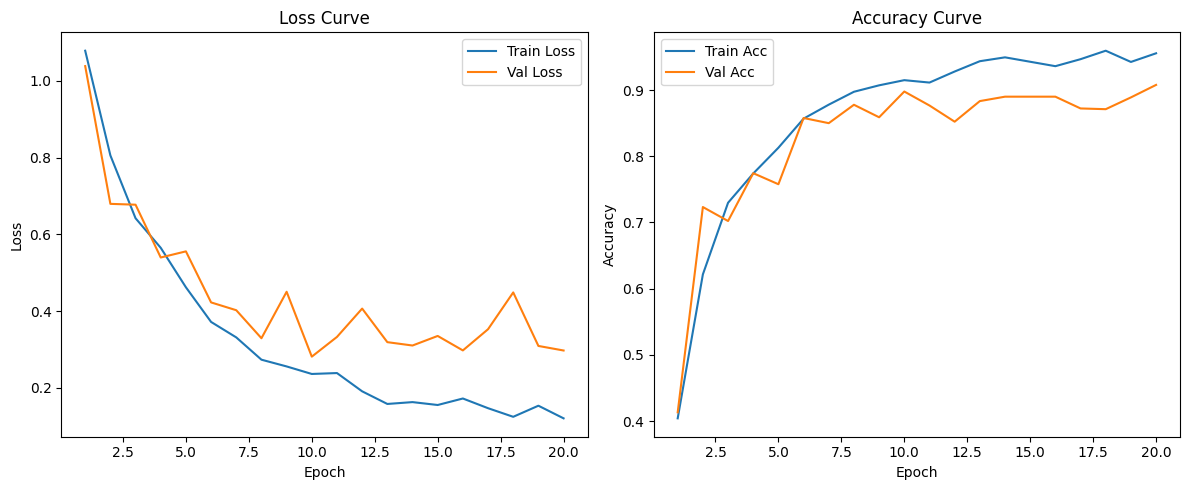

In [ ]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import mne
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Load & epoch BDF dataset
# -------------------------------------------------------
def load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0):
    """
    Expected folder structure:
      sub-pdX/ses-on/eeg/*.bdf  -> label 1 (PD ON)
      sub-pdX/ses-off/eeg/*.bdf -> label 0 (PD OFF)
      sub-hcX/ses-hc/eeg/*.bdf  -> label 2 (Healthy Control)
    """
    X, y = [], []
    n_times = int(sfreq * epoch_len)
    bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)
    print(f"Found {len(bdf_files)} BDF files")

    for f in bdf_files:
        f_low = f.lower()
        if "/ses-on/" in f_low:
            label = 1
        elif "/ses-off/" in f_low:
            label = 0
        elif "/ses-hc/" in f_low:
            label = 2
        else:
            print(f"Skipping unknown label: {f}")
            continue
        try:
            raw = mne.io.read_raw_bdf(f, preload=True, verbose=False)
            raw.resample(sfreq)
            raw.pick_types(eeg=True)
            data = raw.get_data()  # (channels, total_samples)
            n_ch, total_time = data.shape

            step = n_times
            for start in range(0, total_time - n_times, step):
                seg = data[:, start:start+n_times]
                if seg.shape[1] == n_times:
                    X.append(seg)
                    y.append(label)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    if len(X) == 0:
        raise RuntimeError("No epochs extracted. Check paths.")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    print("✅ Dataset shape:", X.shape, y.shape)
    return X, y

# -------------------------------------------------------
# 2. Hybrid CNN + Transformer model
# -------------------------------------------------------
class CNNTransformer(nn.Module):
    """
    CNN extracts local spatio-temporal features
    Transformer models long-range temporal dependencies
    """
    def __init__(self, n_channels, n_classes, time_len,
                 cnn_out_dim=64, trans_dim=128, nhead=4, num_layers=2):
        super().__init__()
        # --- CNN backbone ---
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(n_channels, 7), stride=(1, 2))
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, cnn_out_dim, kernel_size=(1, 5), stride=(1, 2))
        self.bn2   = nn.BatchNorm2d(cnn_out_dim)

        # compute temporal length after convs to create tokens
        def out_len(l, k, s): return (l - k)//s + 1
        t1 = out_len(time_len, 7, 2)
        t2 = out_len(t1, 5, 2)
        self.token_len = t2  # number of tokens after CNN
        self.proj = nn.Linear(cnn_out_dim, trans_dim)

        # --- Transformer encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=nhead, dim_feedforward=trans_dim*4,
            batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.randn(1, 1, trans_dim))
        self.pos_emb   = nn.Parameter(torch.randn(1, 1 + self.token_len, trans_dim))

        self.fc = nn.Linear(trans_dim, n_classes)

    def forward(self, x):
        # x: (B, C, T)
        x = x.unsqueeze(1)  # (B,1,C,T)
        x = F.relu(self.bn1(self.conv1(x)))      # (B,16,1,T1)
        x = F.relu(self.bn2(self.conv2(x)))      # (B,C_out,1,T2)
        x = x.squeeze(2).transpose(1,2)          # (B,T2,C_out) tokens
        x = self.proj(x)                         # (B,T2,D)

        # add [CLS] token
        B = x.size(0)
        cls = self.cls_token.expand(B, -1, -1)   # (B,1,D)
        tokens = torch.cat([cls, x], dim=1)      # (B,1+T2,D)

        tokens = tokens + self.pos_emb[:, :tokens.size(1)]
        out = self.transformer(tokens)           # (B,1+T2,D)
        cls_out = out[:,0]                       # CLS representation
        return self.fc(cls_out)

# -------------------------------------------------------
# 3. Training & evaluation
# -------------------------------------------------------
def run_epoch(model, loader, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if train:
                optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            preds.append(out.argmax(1).cpu())
            targets.append(yb.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average='macro', zero_division=0)
    rec  = recall_score(targets, preds, average='macro', zero_division=0)
    f1   = f1_score(targets, preds, average='macro', zero_division=0)
    return total_loss/len(loader.dataset), acc, prec, rec, f1

# -------------------------------------------------------
# 4. Main
# -------------------------------------------------------
def main():
    base_path = "/content/drive/MyDrive/archive (1)"  # <-- change to your root folder
    X, y = load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0)

    # Normalization
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

    # Train/validation split
    n = len(X)
    idx = np.random.permutation(n)
    split = int(0.8 * n)
    train_idx, val_idx = idx[:split], idx[split:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_channels, time_len = X.shape[1], X.shape[2]

    model = CNNTransformer(n_channels=n_channels, n_classes=3, time_len=time_len,
                           cnn_out_dim=64, trans_dim=128,
                           nhead=4, num_layers=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss":[], "val_loss":[],
               "train_acc":[],  "val_acc":[],
               "train_f1":[],   "val_f1":[]}

    for epoch in range(1, 21):
        tr_loss, tr_acc, tr_prec, tr_rec, tr_f1 = run_epoch(model, train_loader,
                                                            optimizer, criterion,
                                                            device, train=True)
        val_loss, val_acc, val_prec, val_rec, val_f1 = run_epoch(model, val_loader,
                                                                 optimizer, criterion,
                                                                 device, train=False)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch:02d} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} F1 {tr_f1:.4f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")

    # Save model
    torch.save(model.state_dict(), "cnn_transformer_eeg.pt")
    print("✅ Model saved to cnn_transformer_eeg.pt")

    # -------------------------------------------------------
    # 5. Plotting
    # -------------------------------------------------------
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Found 46 BDF files
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1 event found on stim channel Status
Event IDs: [1]
Finding events on: Status
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removin

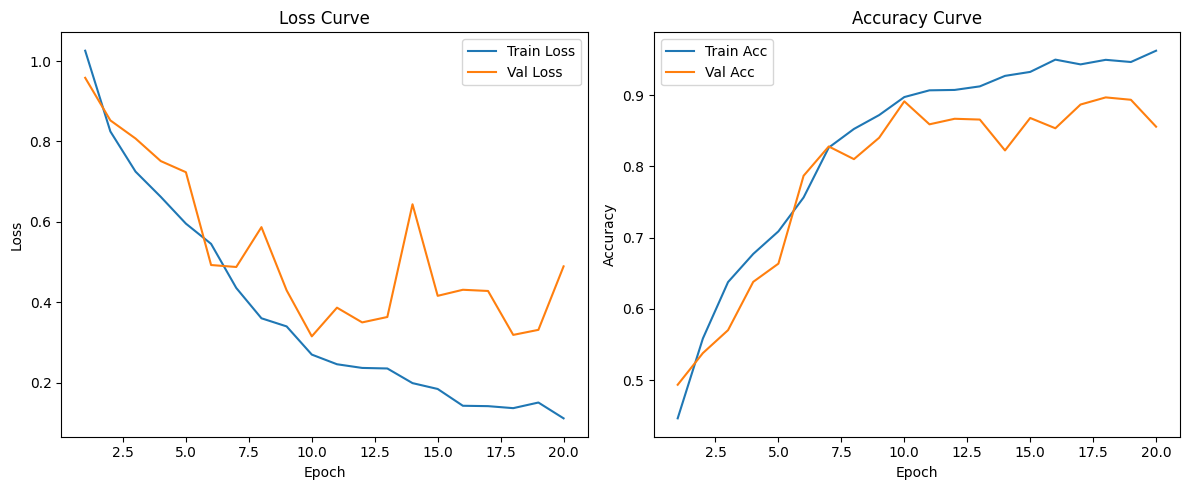

In [ ]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import mne
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Load & epoch BDF dataset
# -------------------------------------------------------
def load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0):
    """
    Expected folder structure:
      sub-pdX/ses-on/eeg/*.bdf  -> label 1 (PD ON)
      sub-pdX/ses-off/eeg/*.bdf -> label 0 (PD OFF)
      sub-hcX/ses-hc/eeg/*.bdf  -> label 2 (Healthy Control)
    """
    X, y = [], []
    n_times = int(sfreq * epoch_len)
    bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)
    print(f"Found {len(bdf_files)} BDF files")

    for f in bdf_files:
        f_low = f.lower()
        if "/ses-on/" in f_low:
            label = 1
        elif "/ses-off/" in f_low:
            label = 0
        elif "/ses-hc/" in f_low:
            label = 2
        else:
            print(f"Skipping unknown label: {f}")
            continue
        try:
            raw = mne.io.read_raw_bdf(f, preload=True, verbose=False)
            raw.resample(sfreq)
            raw.pick_types(eeg=True)
            data = raw.get_data()  # (channels, total_samples)
            n_ch, total_time = data.shape

            step = n_times
            for start in range(0, total_time - n_times, step):
                seg = data[:, start:start+n_times]
                if seg.shape[1] == n_times:
                    X.append(seg)
                    y.append(label)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    if len(X) == 0:
        raise RuntimeError("No epochs extracted. Check paths.")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    print("✅ Dataset shape:", X.shape, y.shape)
    return X, y

# -------------------------------------------------------
# 2. Hybrid CNN + Transformer model
# -------------------------------------------------------
class CNNTransformer(nn.Module):
    """
    CNN extracts local spatio-temporal features
    Transformer models long-range temporal dependencies
    """
    def __init__(self, n_channels, n_classes, time_len,
                 cnn_out_dim=64, trans_dim=128, nhead=4, num_layers=2):
        super().__init__()
        # --- CNN backbone ---
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(n_channels, 7), stride=(1, 2))
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, cnn_out_dim, kernel_size=(1, 5), stride=(1, 2))
        self.bn2   = nn.BatchNorm2d(cnn_out_dim)

        # compute temporal length after convs to create tokens
        def out_len(l, k, s): return (l - k)//s + 1
        t1 = out_len(time_len, 7, 2)
        t2 = out_len(t1, 5, 2)
        self.token_len = t2  # number of tokens after CNN
        self.proj = nn.Linear(cnn_out_dim, trans_dim)

        # --- Transformer encoder ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=nhead, dim_feedforward=trans_dim*4,
            batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_token = nn.Parameter(torch.randn(1, 1, trans_dim))
        self.pos_emb   = nn.Parameter(torch.randn(1, 1 + self.token_len, trans_dim))

        self.fc = nn.Linear(trans_dim, n_classes)

    def forward(self, x):
        # x: (B, C, T)
        x = x.unsqueeze(1)  # (B,1,C,T)
        x = F.relu(self.bn1(self.conv1(x)))      # (B,16,1,T1)
        x = F.relu(self.bn2(self.conv2(x)))      # (B,C_out,1,T2)
        x = x.squeeze(2).transpose(1,2)          # (B,T2,C_out) tokens
        x = self.proj(x)                         # (B,T2,D)

        # add [CLS] token
        B = x.size(0)
        cls = self.cls_token.expand(B, -1, -1)   # (B,1,D)
        tokens = torch.cat([cls, x], dim=1)      # (B,1+T2,D)

        tokens = tokens + self.pos_emb[:, :tokens.size(1)]
        out = self.transformer(tokens)           # (B,1+T2,D)
        cls_out = out[:,0]                       # CLS representation
        return self.fc(cls_out)

# -------------------------------------------------------
# 3. Training & evaluation
# -------------------------------------------------------
def run_epoch(model, loader, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, preds, targets = 0, [], []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if train:
                optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            if train:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * xb.size(0)
            preds.append(out.argmax(1).cpu())
            targets.append(yb.cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average='macro', zero_division=0)
    rec  = recall_score(targets, preds, average='macro', zero_division=0)
    f1   = f1_score(targets, preds, average='macro', zero_division=0)
    return total_loss/len(loader.dataset), acc, prec, rec, f1

# -------------------------------------------------------
# 4. Main
# -------------------------------------------------------
def main():
    base_path = "/content/drive/MyDrive/archive (1)"  # <-- change to your root folder
    X, y = load_bdf_dataset(base_path, sfreq=256, epoch_len=2.0)

    # Normalization
    X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

    # Train/validation split
    n = len(X)
    idx = np.random.permutation(n)
    split = int(0.8 * n)
    train_idx, val_idx = idx[:split], idx[split:]
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_channels, time_len = X.shape[1], X.shape[2]

    model = CNNTransformer(n_channels=n_channels, n_classes=3, time_len=time_len,
                           cnn_out_dim=64, trans_dim=128,
                           nhead=4, num_layers=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss":[], "val_loss":[],
               "train_acc":[],  "val_acc":[],
               "train_f1":[],   "val_f1":[]}

    for epoch in range(1, 21):
        tr_loss, tr_acc, tr_prec, tr_rec, tr_f1 = run_epoch(model, train_loader,
                                                            optimizer, criterion,
                                                            device, train=True)
        val_loss, val_acc, val_prec, val_rec, val_f1 = run_epoch(model, val_loader,
                                                                 optimizer, criterion,
                                                                 device, train=False)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)
        history["train_f1"].append(tr_f1)
        history["val_f1"].append(val_f1)

        print(f"Epoch {epoch:02d} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} F1 {tr_f1:.4f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")

    # Save model
    torch.save(model.state_dict(), "cnn_transformer_eeg.pt")
    print("✅ Model saved to cnn_transformer_eeg.pt")

    # -------------------------------------------------------
    # 5. Plotting
    # -------------------------------------------------------
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label='Train Acc')
    plt.plot(epochs, history["val_acc"], label='Val Acc')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 120.2 MB/s eta 0:00:00
Extracting EDF parameters from /content/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


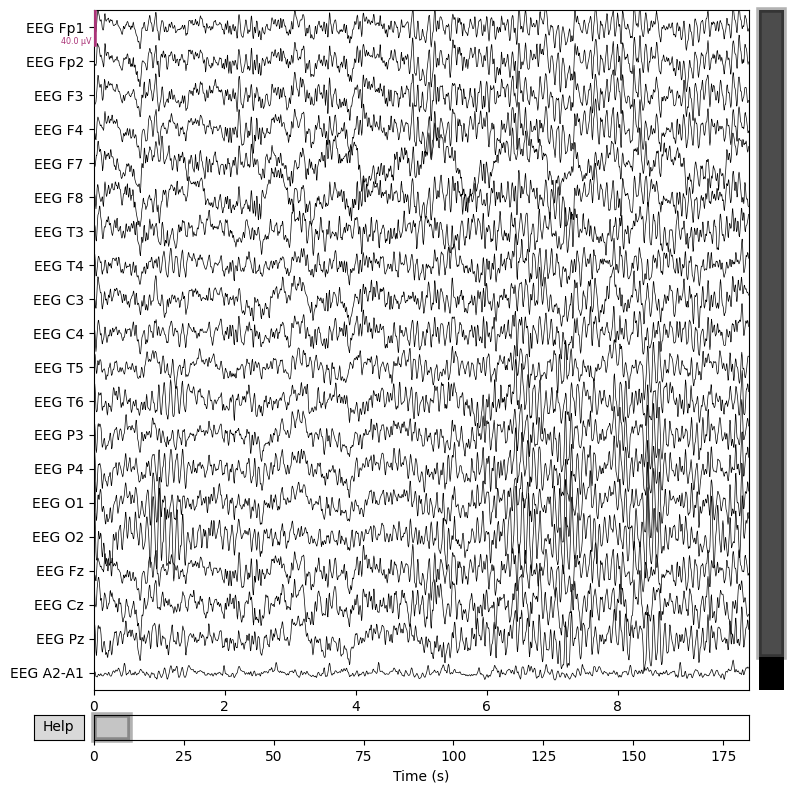

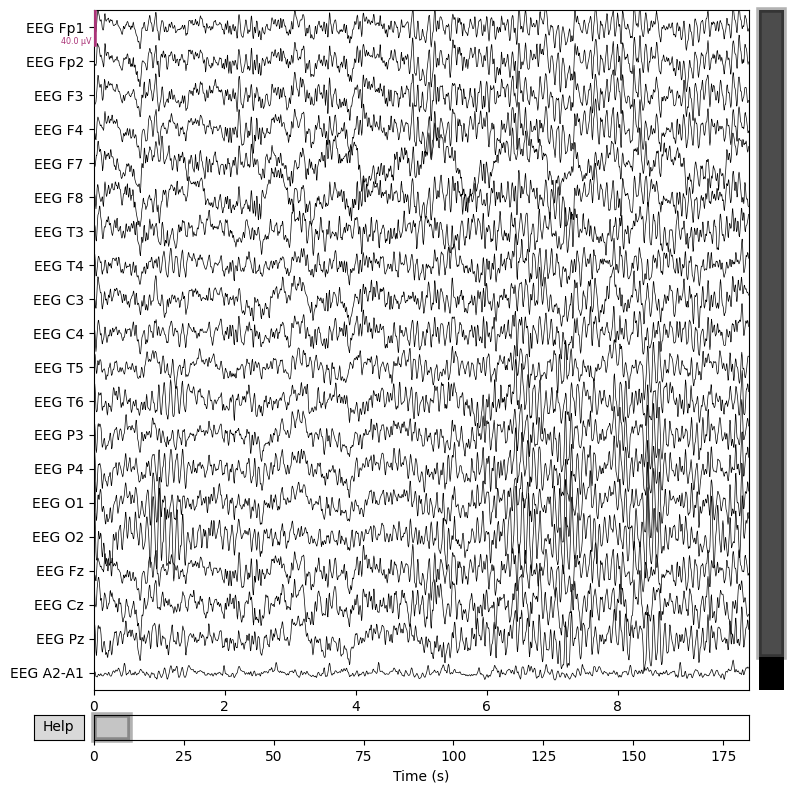

In [ ]:
!pip install mne
import mne
data = mne.io.read_raw_edf("/content/Subject00_1.edf")
data.plot()

Extracting EDF parameters from /content/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


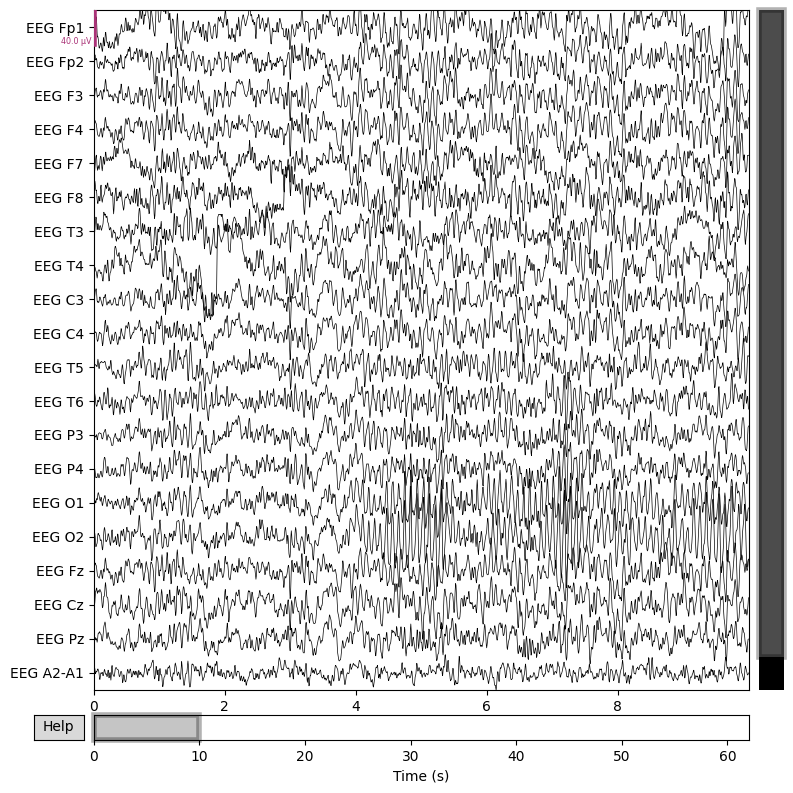

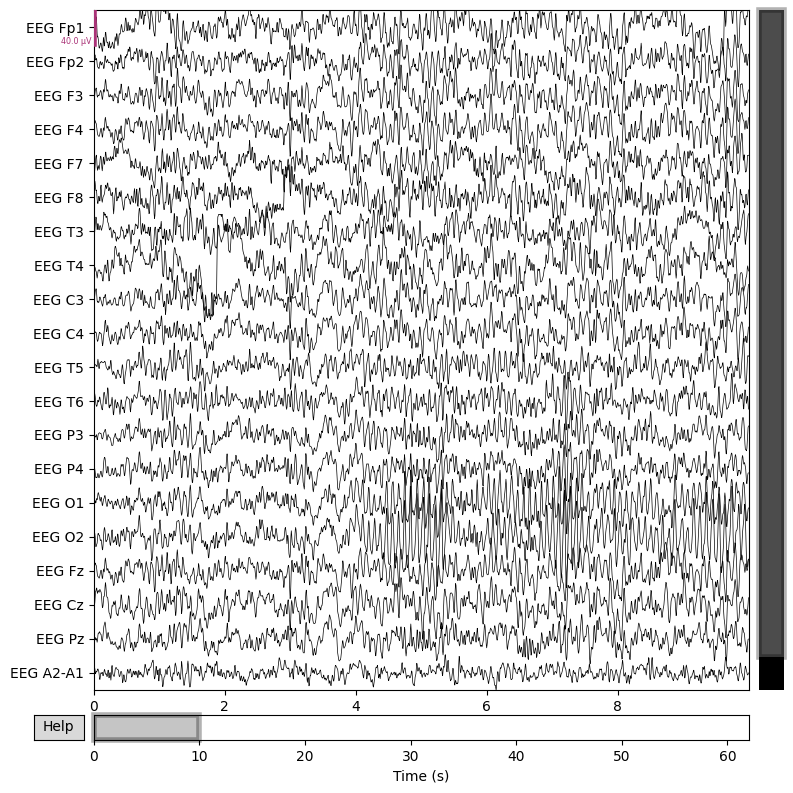

In [ ]:
data1 = mne.io.read_raw_edf("/content/Subject00_1.edf")
data2 = mne.io.read_raw_edf("/content/Subject00_2.edf")
#data1.plot()
data2.plot()